# Task 8. Practical analysis of advanced algorithms

In [1]:
import networkx as nx
from networkx.utils import UnionFind
import numpy as np
from copy import deepcopy

from scipy.optimize import curve_fit

import matplotlib.pyplot as plt

import time
import random

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject



## Assignment

Choose two algorithms (interesting to you and not considered in the course).

Analyse the chosen algorithms in terms of time and space complexity, design technique used, etc. Implement the algorithms and produce several experiments. Analyse the results.

## Part 1. Johnson's algorithm analysis

### Johnson's algorithm implementation. 

The function computes and returns all possible shortest paths weights for all pairs of vertices. 

To implement this algorithm we used a discription of it from "Introduction to Algorithms" by Thomas H. Cormen et al., Third Edition: paragraph 25.3 (Johnson’s algorithm for sparse graphs).

In [2]:
def johnson(Grph, weight='weight'):
    
    G = deepcopy(Grph) # Compute extended graph G': G'.V = G.V + {s}, G'.E = G.E + {(s, v): v in G.V} and w(s, v) = 0 for all v in G.V.
    
    s = G.number_of_nodes()
    G.add_node(s)  
    for v in G.nodes():
        G.add_edge(s, v, weight=0)   

    try:
        dist_bellman = nx.single_source_bellman_ford_path_length(G, s, weight=weight)
    except nx.NetworkXUnbounded:
        print('The input graph contains a negative-weight cycle.')
        
    for (u, v, w) in G.edges(data=True): 
        w[weight] = w[weight] + dist_bellman[u] - dist_bellman[v] # Update the weight function to take into account the Bellman--Ford distances.

    dijkstra_paths = {v: nx.single_source_dijkstra_path_length(G, v, weight=weight) for v in G.nodes()}
    
    G.remove_node(s)
    all_pairs_path_lenght = {}

    for u in G.nodes():
        a = dijkstra_paths[u]
        all_pairs_path_lenght[u] = {}
        for v in a.keys():
            all_pairs_path_lenght[u][v] = a[v] + dist_bellman[v] - dist_bellman[u]

    return all_pairs_path_lenght

### Representing the work of the algorithm
Let's test an implemented algorithm on simple directed acyclic graph (DAG) with 4 nodes.  
Note: We use directed graph, because any undireted graph with negative weights contains negative cycles.

In [3]:
n, m = 4, 5
G = nx.generators.random_graphs.gnm_random_graph(n, m)
graph = nx.DiGraph([(u, v, {'weight': random.randint(-10, 10)}) for (u, v) in G.edges() if u < v]) # random directed acyclic graph 
del(G)

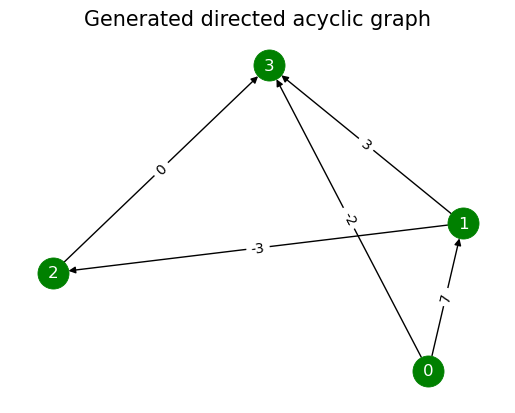

In [4]:
pos = nx.spring_layout(graph, seed=1000, iterations=100)

plt.title('Generated directed acyclic graph', fontsize=15)
nx.draw(graph, pos,
        with_labels=True,
        node_size=500,
        font_color='white',
        node_color='green',
        linewidths=0.6)

edge_labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)


plt.savefig('directed_acyclic_graph.pdf')
plt.show()

As we can see, algorithm works correctly:

In [5]:
all_pairs_paths_weights = johnson(graph)
print('Weight of the shortest paths from each node to others (if there are edges):',  all_pairs_paths_weights)

Weight of the shortest paths from each node to others (if there are edges): {0: {0: 0, 3: -2, 1: 7, 2: 4}, 3: {3: 0}, 1: {1: 0, 2: -3, 3: -3}, 2: {2: 0, 3: 0}}


### Time complexity analysis

In [6]:
def mean_exec_time(function, *args, **kwargs):
    """Returns averaged execution time of the function by five runs"""
    tau = []
    for _ in range(n):
        init_time = time.time()
        function(*args, **kwargs)
        tau.append(time.time() - init_time)
        
    return  round(sum(tau)/len(tau), 5)

def random_dag_generator(n, m):
    """Generates and returns random directed acyclic graph with n nodes and m edges."""
    G = nx.generators.random_graphs.gnm_random_graph(n, m)
    DAG = nx.DiGraph([(u, v, {'weight': random.randint(-10, 10)}) for (u, v) in G.edges() if u < v]) 
    return DAG

Asymptotic time complexity is a  V$^2$ lg V + b V  E,  where V and E number of vertices and edges correspondingly. 

In the case of complete graph upper bound time complexity is O(V$^3$), but for sparse graph O(V$^2$ lg V + VE).

In our case to simplify analysis we chose E = 5 V, so we will find T(V) ~ a V$^2$ lg V + b V$^2$

In [7]:
def asymptotic_time_johnsons(vert_num, a, b):
    return a * vert_num ** 2 * np.log10(vert_num) + b * vert_num ** 2

We will run algorithm for |V|$\in [11, 100]$ and |E|$=10$|V| and keep track of time.
In this case the sparse condition E$\ll$V(V-1) is met for big numbers of nodes.

In [8]:
exec_time = []
v_num = np.arange(11, 100)

for n in v_num:
    m = 5 * n
    graph = random_dag_generator(n, m)
    exec_time.append(mean_exec_time(johnson, graph))
    

In [9]:
popt = curve_fit(asymptotic_time_johnsons, v_num, exec_time)[0]

In [10]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (5.5, 3.8)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

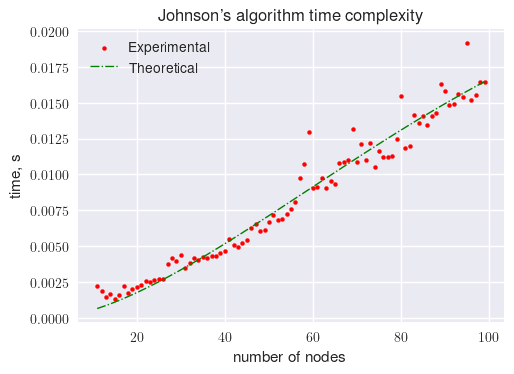

In [11]:
plt.title('Johnson\'s algorithm time complexity')
plt.scatter(v_num, exec_time, s=8, c='r', label='Experimental')
plt.plot(v_num, asymptotic_time_johnsons(v_num, *popt), c='green', linewidth=1, linestyle='-.', label='Theoretical')
plt.ylabel('time, s')
plt.xlabel('number of nodes')
plt.legend()

plt.savefig('johnsons_time_complexity.pdf')

plt.show()

Spase complexity analysis is discussed in the report on work. 

## Part 2. Minimum spanning tree search (Kruskal) algorithm analysis

### Kruskal algorithm implementation

The Kruskal algorithm finds minimum spanning tree (MST) of weighted graph using greedy strategy. On each step it grows the minimum spanning tree one edge at a time. While growing a tree, algorithm adds edges that would not create cycles.


To implement this algorithm we used a discription of it from "Introduction to Algorithms" by Thomas H. Cormen et al., Third Edition: paragraph 23.2 (The algorithms of Kruskal and Prim).

In [12]:
def minimum_spanning_edges(G, weight='weight', data=True):
    
    # creating a union-find data structure, that maintains a family of disjoint sets of hashable objects:
    subtrees = UnionFind() 

    edges = sorted(G.edges(data=True), key=lambda t: t[2].get(weight, 1)) # sort edges in nondecreasing order by weight
    
    for u, v, d in edges:
        if subtrees[u] != subtrees[v]: # checking if both u and v belong to the tree and add edge to the tree if not
            if data:
                yield (u, v, d)
            else:
                yield (u, v)
            subtrees.union(u, v)
            

In [13]:
def minimum_spanning_tree(G, weight='weight'):
   
    edges = minimum_spanning_edges(G, weight, data=True)
    
    T = G.__class__() 
    T.graph.update(G.graph)
    T.add_nodes_from(G.nodes.items())
    T.add_edges_from(edges)
    return T

### Representing the work of the algorithm

Let's test an implemented algorithm on complete udirected weighted graph with 4 nodes.

In [14]:
n = 4
graph = nx.generators.complete_graph(n)

for (u,v,w) in graph.edges(data=True):
    w['weight'] = random.randint(0,10)

In [15]:
plt.style.use('default')

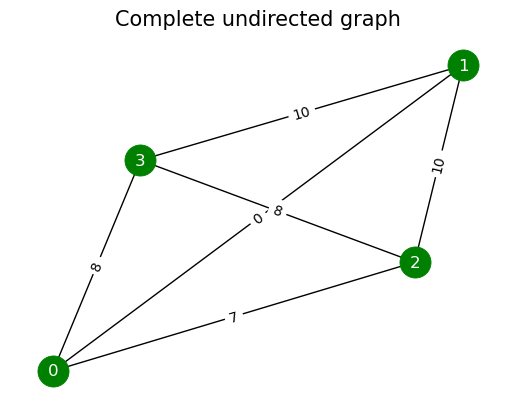

In [16]:
pos = nx.spring_layout(graph, seed=1000, iterations=100)

plt.title('Complete undirected graph', fontsize=15)
nx.draw(graph, pos,
        with_labels=True,
        node_size=500,
        font_color='white',
        node_color='green',
        linewidths=0.6)

edge_labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

plt.savefig('complete_graph.pdf')
plt.show()

Application the algorithm to the complete graph.

In [17]:
min_spanning_tree =  minimum_spanning_tree(graph)

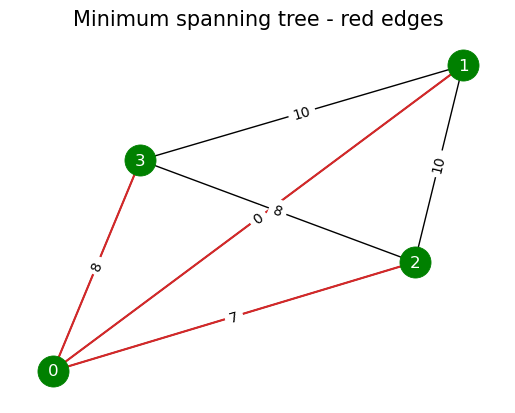

In [18]:
plt.title('Minimum spanning tree - red edges', fontsize=15)

nx.draw(graph, pos,
        with_labels=True,
        node_size=500,
        font_color='white',
        node_color='green',
        linewidths=0.6)

nx.draw_networkx_edges(
    graph, pos,
    edgelist=min_spanning_tree.edges(),
    width=1.5, 
    alpha=1, 
    edge_color="tab:red")


edge_labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

plt.savefig('kruskal_example.pdf')

plt.show()

### Time complexity analysis

In [19]:
def asymptotic_time_kruskal(edges_num, a):
    return a * edges_num * np.log10(edges_num) 

In [20]:
exec_time = []
v_num = np.arange(2, 100)
e_num = v_num * (v_num - 1) / 2

for n in v_num:
    graph = nx.generators.complete_graph(n)

    for (u,v,w) in graph.edges(data=True):
        w['weight'] = random.randint(0,10)
        
    exec_time.append(mean_exec_time(minimum_spanning_tree, graph))

In [21]:
popt = curve_fit(asymptotic_time_kruskal, e_num, exec_time)[0]

In [22]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (5.5, 3.8)

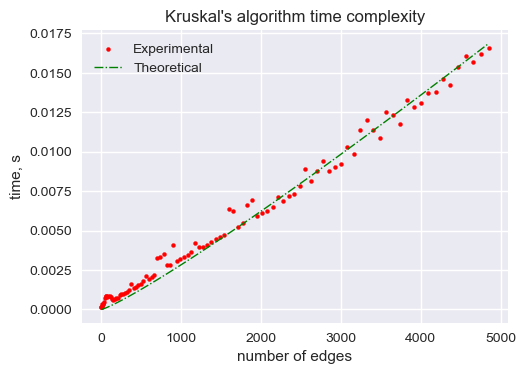

In [23]:
plt.title('Kruskal\'s algorithm time complexity')
plt.scatter(e_num, exec_time, s=8, c='r', label='Experimental')
plt.plot(e_num, asymptotic_time_kruskal(e_num, *popt), c='green', linewidth=1, linestyle='-.', label='Theoretical')
plt.ylabel('time, s')
plt.xlabel('number of edges')
plt.legend()

plt.savefig('kruskals_time_complexity.pdf')

plt.show()